##  https://github.com/QuKunLab/SpatialBenchmarking

In [1]:
import warnings
# Filter out warning messages
warnings.filterwarnings("ignore")

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess

import os

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
from scipy.sparse import csr_matrix
from cell2location.utils.filtering import filter_genes

In [3]:
## setting for STARmap
sc_file_path = "/home/comp/cszrwang/data/Melanoma/sc_mela.h5ad"
spatial_file_path = "/home/comp/cszrwang/data/Melanoma/st_mela.h5ad"
celltype_key = 'celltype'
output_file_path = "/home/comp/cszrwang/results/Deconvolution/results/Melanoma/Cell2location/"
if not os.path.exists(output_file_path):
    os.mkdir(output_file_path)

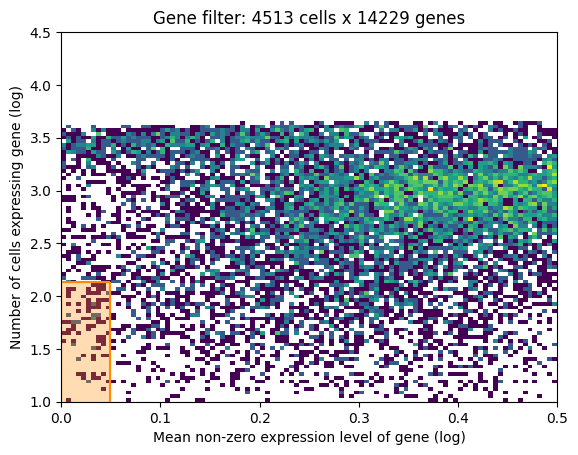

In [4]:
adata_snrna_raw = sc.read_h5ad(sc_file_path)
adata_vis = sc.read_h5ad(spatial_file_path)
adata_snrna_raw.X = csr_matrix(adata_snrna_raw.X)
adata_vis.X = csr_matrix(adata_vis.X)

adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs[celltype_key].isin(np.array(adata_snrna_raw.obs[celltype_key].value_counts()[adata_snrna_raw.obs[celltype_key].value_counts() <=1].index))]

# remove cells and genes with 0 counts everywhere
sc.pp.filter_genes(adata_snrna_raw,min_cells=1)
sc.pp.filter_cells(adata_snrna_raw,min_genes=1)

adata_snrna_raw.obs[celltype_key] = pd.Categorical(adata_snrna_raw.obs[celltype_key])
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs[celltype_key].isna(), :]

selected = filter_genes(adata_snrna_raw, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_snrna_raw = adata_snrna_raw[:, selected].copy()

In [5]:
if adata_snrna_raw.X.dtype != int:
#     adata_snrna_raw.X = (adata_snrna_raw.X * 1000).astype(int)
    adata_snrna_raw.X = (adata_snrna_raw.X).astype(int)

In [6]:
# create and train the regression model
from cell2location.models import RegressionModel

RegressionModel.setup_anndata(adata=adata_snrna_raw,labels_key=celltype_key)

mod = RegressionModel(adata_snrna_raw)

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
#mod.plot_history(20)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 250/250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:35<00:00,  1.67it/s, v_num=1, elbo_train=4.87e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:10<00:00, 96.38it/s]


In [7]:
from cell2location.models import Cell2location

In [8]:
# prepare anndata for cell2location model
Cell2location.setup_anndata(adata=adata_vis)
#scvi.data.view_anndata_setup(adata_vis)

In [9]:
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
)

mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
# mod.plot_history(1000)
# plt.legend(labels=['full data training'])

adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [50:23<00:00, 36.08it/s, v_num=1, elbo_train=1.99e+6]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:20<00:00, 48.20it/s]


In [10]:
print(adata_vis)

AnnData object with n_obs × n_vars = 293 × 14229
    obs: 'n_genes', 'index', 'x', 'y', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'


In [11]:
adata_vis.obsm['q05_cell_abundance_w_sf'].columns = adata_vis.obsm['q05_cell_abundance_w_sf'].columns.to_series().apply(lambda x: x.split('_')[-1])
adata_vis.obsm['q05_cell_abundance_w_sf'].columns

Index(['B', 'CAF', 'Endo', 'Macro', 'Mal', 'NK', 'T'], dtype='object')

In [12]:
adata_vis.obsm['q05_cell_abundance_w_sf'].to_csv(output_file_path + '/Cell2location_result.csv')